In [1]:
import pandas as pd
from pathlib import Path
import sys
import os
import numpy as np
import re


sys.path.append(os.path.abspath('../src'))
project_dir = project_dir = Path.cwd().parent
period = "M"

In [2]:
# Combine all tsv into one

dfs = []

for folder in ["DENV-1", "DENV-2", "DENV-3", "DENV-4"]:
    base_folder_path = project_dir / "data" / "raw" / folder
    files = [f for f in os.listdir(base_folder_path) if f.endswith('.tsv')]
   
    for file in files:

        file_path = os.path.join(base_folder_path, file)
        df = pd.read_csv(file_path, sep='\t')
        df['Sero'] = folder
        dfs.append(df)


denv_df = pd.concat(dfs)
denv_df = denv_df.drop_duplicates()
denv_df

,Accession ID,Collection date,Submission date,Location,Sero
0,EPI_ISL_10331061,2020-07-29,2022-02-25,North America / USA / Florida / Monroe County,DENV-1
1,EPI_ISL_10331624,2020-07-29,2022-02-25,North America / USA / Florida / Monroe County,DENV-1
2,EPI_ISL_10331626,2020-07-27,2022-02-25,North America / USA / Florida / Monroe County,DENV-1
3,EPI_ISL_10331627,2020-07-26,2022-02-25,North America / USA / Florida / Monroe County,DENV-1
4,EPI_ISL_10331628,2020-07-06,2022-02-25,North America / USA / Florida / Monroe County,DENV-1
...,...,...,...,...,...
1470,EPI_ISL_985403,2018-09,2021-02-15,Asia / India / Delhi,DENV-4
1471,EPI_ISL_996005,2018-09,2021-02-15,Asia / India / Delhi,DENV-4
1472,EPI_ISL_996007,2018-09,2021-02-15,Asia / India / Delhi,DENV-4
1473,EPI_ISL_996026,2018-09,2021-02-15,Asia / India / Delhi,DENV-4


In [3]:
# Format dates to Year-Month, with only year readings assumed to be Jan
def fix_date(val):
    if isinstance(val, str):
        val = val.strip()

        # Year only: "2018"
        if re.fullmatch(r"\d{4}", val):
            return f"{val}-01-01"
        
        # Year-Month: "2018-07" or "2018/07"
        if re.fullmatch(r"\d{4}[-/]\d{1,2}", val):
            parts = re.split("[-/]", val)
            year, month = parts
            return f"{year}-{int(month):02d}-01"
        
        # Month-Year: "07/2018" or "07-2018"
        if re.fullmatch(r"\d{1,2}[-/]\d{4}", val):
            parts = re.split("[-/]", val)
            month, year = parts
            return f"{year}-{int(month):02d}-01"
        
    return val  # Leave as-is if not matched

# Clean up dates on monthly scale
denv_df['Collection date'] = denv_df['Collection date'].apply(fix_date)
denv_df['Submission date'] = denv_df['Submission date'].apply(fix_date)

denv_df['Collection date'] = pd.to_datetime(denv_df['Collection date']).dt.to_period(period)
denv_df['Submission date'] = pd.to_datetime(denv_df['Submission date']).dt.to_period(period)


denv_df['Delay'] = np.array((denv_df['Submission date'] - denv_df['Collection date']).apply(lambda x: x.n))
denv_df = denv_df.sort_values("Collection date")
denv_df['Month'] = denv_df['Collection date'].dt.month
denv_df = denv_df[denv_df['Delay'] >= 0]

denv_df


,Accession ID,Collection date,Submission date,Location,Sero,Delay,Month
4759,EPI_ISL_18748497,2006-01,2017-02,Asia / Thailand,DENV-1,133,1
1144,EPI_ISL_17450408,2006-01,2008-01,Asia / India / Delhi,DENV-3,24,1
1145,EPI_ISL_17450409,2006-01,2008-01,Asia / India / Delhi,DENV-3,24,1
4197,EPI_ISL_17610942,2006-01,2012-04,Asia / Thailand,DENV-1,75,1
1147,EPI_ISL_17450416,2006-01,2008-10,Asia / India / Delhi,DENV-3,33,1
...,...,...,...,...,...,...,...
1222,EPI_ISL_19707671,2024-12,2025-02,South America / Ecuador / Napo,DENV-3,2,12
1223,EPI_ISL_19707672,2024-12,2025-02,South America / Ecuador / Napo,DENV-3,2,12
1224,EPI_ISL_19707673,2024-12,2025-02,South America / Ecuador / Napo,DENV-3,2,12
1236,EPI_ISL_19720256,2024-12,2025-02,South America / Peru / San Martin,DENV-3,2,12


In [4]:
denv_df.to_csv(project_dir / "data" / "transformed" / 'denv_df.csv', index=False)

In [5]:
# Create full grid of Month × Sero combinations
start_month = denv_df['Collection date'].min()
end_month = denv_df['Collection date'].max()
months_all = pd.period_range(start=start_month, end=end_month, freq=period)
sero_all = denv_df['Sero'].unique()



sero_date_combos = pd.MultiIndex.from_product(
    [months_all, sero_all], names=['Collection date', 'Sero']
).to_frame(index=False)

sero_counts = denv_df.groupby(['Collection date', 'Sero']).size().reset_index(name='Count')
sero_full_counts = pd.merge(sero_date_combos, sero_counts, on=['Collection date', 'Sero'], how='left')
sero_full_counts['Count'] = sero_full_counts['Count'].fillna(0).astype(int)
sero_full_counts['Proportion'] = sero_full_counts['Count'] / sero_full_counts.groupby('Collection date')['Count'].transform('sum')
sero_full_counts = sero_full_counts.sort_values(['Sero', 'Collection date']).reset_index(drop=True)
sero_full_counts

# will contain NaN for months that had no obs
unobserved_months = sero_full_counts[sero_full_counts['Proportion'].isna()]['Collection date'].unique()
print(unobserved_months)

# Need to backfill with a previous months prop
for month in unobserved_months:
    filled = False
    for lag in range(1, 12):
        prev_month = month - lag
        prev_vals = sero_full_counts.loc[
            sero_full_counts['Collection date'] == prev_month, 'Proportion'
        ]

        if not prev_vals.empty and not prev_vals.isna().any():
            sero_full_counts.loc[
                sero_full_counts['Collection date'] == month, 'Proportion'
            ] = prev_vals.values
            filled = True
            break  # Exit the lag loop

    if not filled:
        print(f"[Warning] Not enough data to backfill for month {month}. Collect more data!")


sero_full_counts



<PeriodArray>
['2006-06']
Length: 1, dtype: period[M]


,Collection date,Sero,Count,Proportion
0,2006-01,DENV-1,851,0.463003
1,2006-02,DENV-1,0,0.000000
2,2006-03,DENV-1,0,0.000000
3,2006-04,DENV-1,0,0.000000
4,2006-05,DENV-1,0,0.000000
...,...,...,...,...
907,2024-08,DENV-4,7,0.027451
908,2024-09,DENV-4,15,0.058140
909,2024-10,DENV-4,7,0.037433
910,2024-11,DENV-4,1,0.009174


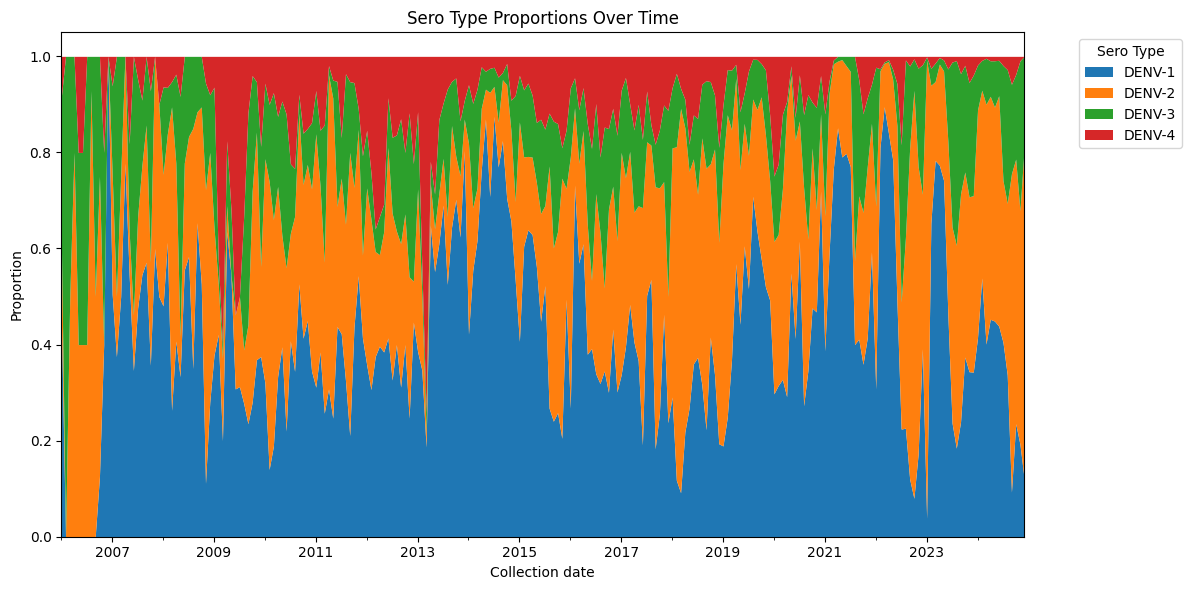

In [6]:
import pandas as pd
import matplotlib.pyplot as plt


sero_full_counts = sero_full_counts.sort_values('Collection date')

# Pivot to wide format: rows = dates, columns = Sero, values = Proportion
pivot_df = sero_full_counts.pivot(index='Collection date', columns='Sero', values='Proportion')
pivot_df = pivot_df.fillna(0)  # Fill missing with 0

# Plot stacked area chart
pivot_df.plot.area(figsize=(12, 6), linewidth=0)
plt.ylabel("Proportion")
plt.title("Sero Type Proportions Over Time")
plt.legend(title="Sero Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [7]:
sero_pivot = sero_full_counts.pivot(index='Collection date', columns='Sero', values='Proportion')
sero_pivot.to_csv(project_dir / "data" / "transformed" / 'sero_props.csv', index=True)
sero_pivot

Sero,DENV-1,DENV-2,DENV-3,DENV-4
Collection date,,,,
2006-01,0.463003,0.161589,0.289989,0.085419
2006-02,0.000000,0.000000,1.000000,0.000000
2006-03,0.000000,0.500000,0.500000,0.000000
2006-04,0.000000,0.800000,0.200000,0.000000
2006-05,0.000000,0.400000,0.400000,0.200000
...,...,...,...,...
2024-08,0.337255,0.356863,0.278431,0.027451
2024-09,0.093023,0.662791,0.186047,0.058140
2024-10,0.235294,0.550802,0.176471,0.037433


In [8]:
np.array(sero_pivot.isna()).sum()


0